In [1]:
# 패키지 import

import os    # OS 자원을 제어할 수 있는 모듈
import cv2    # OpenCV라이브러리
import matplotlib.pyplot as plt    # 도식화 라이브러리
import numpy as np   # 다차원 배열 처리
import dlib     # 이미지 처리 및 기계 학습, 얼굴 인식 등

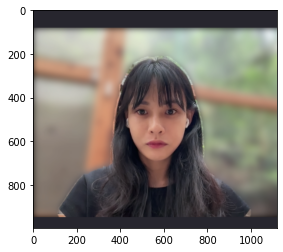

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/gh.png'   # 이미지 저장 경로
img_bgr = cv2.imread(my_image_path)   # OpenCV로 이미지 불러오기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 이미지를 RGB로 보정
img_show_rgb = img_rgb.copy()    # 출력용 이미지 따로 보관
plt.imshow(img_rgb)   # 출력 이미지 올려주기 (실제 출력 X) - 원하는 사이즈 픽셀을 원하는 색으로
plt.show()    # 이미지 출력

In [3]:
img_rgb.shape

(998, 1118, 3)

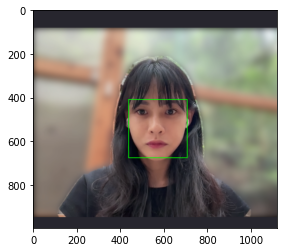

In [3]:
# hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 통해 얼굴 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   # 이미지, 이미지 파라미드수

# 얼굴 영역 bounding box 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    b = dlib_rect.bottom()
    r = dlib_rect.right()
    t = dlib_rect.top()
    
    # 시작점과 종료점 좌표로 직사각형을 그림
    cv2.rectangle(img_show_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) 

plt.imshow(img_show_rgb)
plt.show()

In [5]:
# dlib에서 제공하는 regression tree의 앙상블 모델이 저장된 경로 
model_path = '/aiffel/aiffel/camera_sticker_ex/models/shape_predictor_68_face_landmarks.dat'

# 모델 생성
landmark_predictor = dlib.shape_predictor(model_path)

In [6]:
# (x,y)형태로 랜드마크 좌표를 접근할 수 있도록 list_landmarks 리스트에 저장

list_landmarks = []     # 랜드마크 좌표 저장

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show_rgb, dlib_rect)
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # list_landmarks에 랜드마크 리스트를 저장
    list_landmarks.append(list_points) 

print(len(list_landmarks[0]))

68


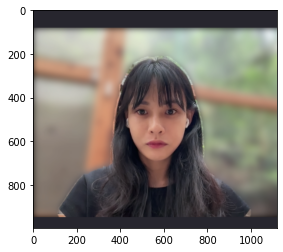

In [7]:
plt.imshow(img_rgb)

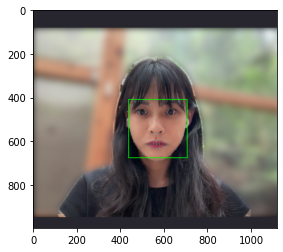

In [8]:
# 랜드마크 영상 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_rgb, point, 2, (0, 255, 255, -1))
        
plt.imshow(img_show_rgb)
plt.show()

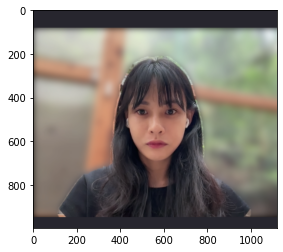

In [9]:
plt.imshow(img_rgb)

## 스티커 적용하기

- 적용 위치: 30번

In [10]:
""" 
    스티커 위치 좌표 (x,y) 계산

"""

POS = landmark[30]
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(POS)    # 코의 index값
    x = POS[0]    # 이미지에서 코의 x축 좌표값
    y = POS[1]    # 이미지에서 코의 y축 좌표값
    w = dlib_rect.width()    # bounding box의 가로 픽셀수
    h = dlib_rect.height()    # bounding box의 세로 픽셀수
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(562, 542)
(x,y) : (562,542)
(w,h) : (269,268)


In [11]:
# 스티커 이미지 불러오기

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png' # 스티커 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정
print(img_sticker.shape) # 사이즈를 조정한 수염 이미지의 차원 확인

(268, 269, 3)


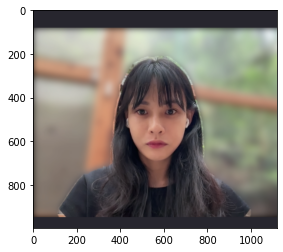

In [12]:
plt.imshow(img_rgb)

In [13]:
# 스티커 시작점 셋팅 (top-left)

refined_x = x - w // 2
refined_y = y - h // 2

print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남

# x, y 좌표가 음수(이미지 범위 벗어남)가 되는 것을 방지하기 위한 좌표 재조정 과정
# 음수 좌표 영역은 잘려나가고 차원이 줄어들게 됨
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 스티커 이미지를 씌우기 위해 수염 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
    
print (f'refined (x,y) : ({refined_x},{refined_y})')
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (428,408)
refined (x,y) : (428,408)


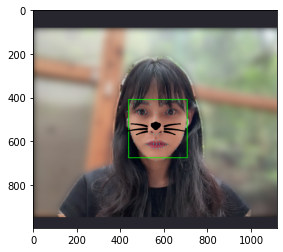

In [14]:
# 
sticker_area = img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker != 0, sticker_area, img_sticker).astype(np.uint8)

# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show_rgb에 스티커를 추가
plt.imshow(img_show_rgb)
# 스티커를 적용한 이미지를 보여주기
plt.show()

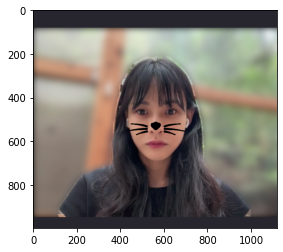

In [18]:
# 원본 rgb파일에 스티커 올리기
sticker_area = img_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(img_rgb) # rgb만 적용해놓은 원본 이미지에 스티커 올린 파일 확인
plt.show()

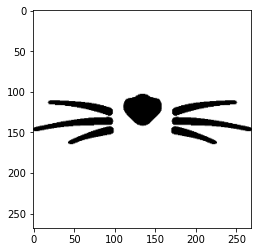

In [20]:
plt.imshow(img_sticker)

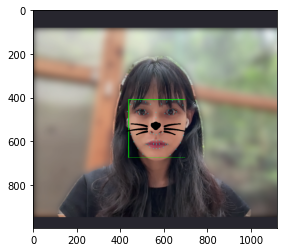

In [14]:
# rgb파일에 스티커 올리기

img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(img_rgb) # rgb만 적용해놓은 원본 이미지에 스티커 올린 파일 확인
plt.show()